# Preprocessing and Modeling

## Contents

-  [Import Data](#Import-Data)
-  [Model Prep](#Model-Prep)
-  [Modeling](#Modeling)
    -  [Baseline Model](#Baseline-Model)
    -  [Logistic Regression](#Logistic-Regression)
        -  [Odds](#Odds)
        -  [Predictions and Probabilities](#Predictions-and-Probabilities)
    -  [Random Forest](#Random-Forest)
        -  [Important Features](#Important-Features)
        -  [Predictions](#Predictions)
-  [Model Comparison](#Model-Comparison)
-  [Conclusions and Recommendations](#Conclusions-and-Recommendations)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

sns.set_style('darkgrid')
sns.set_palette(palette='colorblind')
np.random.seed(44)
%matplotlib inline

/Users/connie/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Import Data

In [2]:
posts = pd.read_csv('../data/all_posts.csv')

In [3]:
posts.head()

,Unnamed: 0,title,selftext,text,digital_nomad,word_count,char_count,text_tokenized,text_meaningful,text_lemmatized
0,0,Where to spend the next month in the USA -,I need to burn a month until mid-January. I ca...,Where to spend the next month in the USA - I n...,1,65,317,"['Where', 'to', 'spend', 'the', 'next', 'month...","['Where', 'spend', 'month', 'USA', 'I', 'need'...",Where spend month USA I need burn month mid Ja...
1,1,Apologies if this is old news,https://tulsaremote.com/,Apologies if this is old news,1,6,31,"['Apologies', 'if', 'this', 'is', 'old', 'news']","['Apologies', 'old', 'news']",Apologies old news
2,2,Where to look for cheap flights around Europe?,I've always heard of people getting £10 flight...,Where to look for cheap flights around Europe?...,1,48,257,"['Where', 'to', 'look', 'for', 'cheap', 'fligh...","['Where', 'look', 'cheap', 'flights', 'Europe'...",Where look cheap flight Europe I heard people ...
3,3,Social media training,Hi all! I am a digital marketing professional ...,Social media training Hi all! I am a marketi...,1,43,265,"['Social', 'media', 'training', 'Hi', 'all', '...","['Social', 'media', 'training', 'Hi', 'I', 'ma...",Social medium training Hi I marketing professi...
4,4,Suggestions for place to live in US? (Preferab...,I'm starting my first remote job in January an...,Suggestions for place to live in US? (Preferab...,1,53,309,"['Suggestions', 'for', 'place', 'to', 'live', ...","['Suggestions', 'place', 'live', 'US', 'Prefer...",Suggestions place live US Preferably semi urba...


Remove `Unnamed: 0` column

In [4]:
posts.drop(columns='Unnamed: 0', inplace=True)

## Model Prep

In [5]:
X = posts[['text_lemmatized']]
y = posts['digital_nomad']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y, 
                                                    random_state=44)

### TF-IDF

Before modeling, we want to use TF-IDF to determine which words are most discriminating between documents. Words that occur frequently are penalized and rare words are given more influence in our model. 

This is preferred over CountVectorizer because it takes into account how many documents contain a term in relation to the entire corpus. Since CountVectorizer only looks at the count, one post that repeatedly uses a word can inflate its frequency. 

We instantiate TfidfVectorizer() and set:
-  `min_df=.03`: ignore terms that have a document frequency lower than 3%. We do not want to include terms that occur in less than 3% of the documents because they can simply be common typos.
-  `max_df=.95`: ignore terms that have a document frequency greater than 95%. We do not want to include terms that occur in almost all documents because they're likely to occur in both subreddits and will not help categorize a given post in one or the other community.

We then create a dataframe for each word and its frequency. This is done for both `X_train` and `X_test`.

##### X_train

In [7]:
tfidf = TfidfVectorizer(min_df=.03, max_df=.95)
X_train_tfidf = tfidf.fit_transform(X_train['text_lemmatized'])
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names())

##### Replicate for X_test

In [8]:
X_test_tfidf = tfidf.transform(X_test['text_lemmatized'])
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf.get_feature_names())

In [9]:
X_test_tfidf_df.shape

(2687, 237)

## Modeling

### Baseline Model

In [10]:
y.value_counts(normalize=True)

0    0.52466
1    0.47534
Name: digital_nomad, dtype: float64

Since r/solotravel is our majority class, an accuracy score of 52.47% is our baseline model. If we classify all posts as belonging in the r/solotravel subreddit, we will be predicting correctly 52.47% of the time.

### Logistic Regression

Logistic Regression predicts continuous probabilities and uses these probabilities to classify something as 0 or 1. It assumes:
-  Linearity between our X variables and the log-odds that `digital_nomad` (Y) = 1
-  Independence of errors
-  Distribution of errors follow a Bernoulli distribution
-  Independence of independent variables (X)

**Reason for Choosing Model:** The coefficients in a logistic regression model is easy to interpret and will allow us to determine which terms should be used as positive and negative keywords in our campaign.

We will instantiate Logistic Regression and perform Grid Search to find the most optimal hyperparameters: 
-  **Penalty:** l1 (lasso) or l2 (ridge) regularization
-  **C:** Inverse of regularization strength. The greater its value, the weaker the regularization strength is. The default value of `1` was included, in addition to our arbitrarily chosen values.

In [11]:
logreg = LogisticRegression()
logreg_params = {
    'penalty':['l1', 'l2'],
    'C': [1, 10, 20]
}
gs_logreg = GridSearchCV(logreg, param_grid=logreg_params, cv=5)
gs_logreg.fit(X_train_tfidf_df, y_train)
print('Score on Training Set:', gs_logreg.score(X_train_tfidf_df, y_train))
print('Score on Testing Set:', gs_logreg.score(X_test_tfidf_df, y_test))
gs_logreg.best_params_

Score on Training Set: 0.8323613351532448
Score on Testing Set: 0.8135467063639747


{'C': 1, 'penalty': 'l1'}

-  For `y_train`, we will correctly predict the class in which a post belongs in 83.24% of the time.
-  For `y_test`, we will correctly predict the class in which a post belongs in 81.35% of the time. 

#### Takeaways
-  There is some slight overfitting, with our training score being 1.89% higher than our test score. 
-  The accuracy scores are greater than our baseline model of `52.47`.
-  Given that we can easily determine how likely, or unlikely a given word will appear in r/digitalnomad, we will move forward with this model and determine what our positive and negative keywords are.

#### Odds

For interpretability sake, we take the exponential of the log odds of successs.

In [12]:
odds_df = pd.DataFrame(np.exp(gs_logreg.best_estimator_.coef_), columns=X_train_tfidf_df.columns).T

In [13]:
odds_df.columns = ['odds']

In [14]:
odds_df.shape[0]

237

The model has a total of 237 features.

In [15]:
odds_df.sort_values(by='odds', ascending=False)[['odds']].head()

,odds
remote,10484.670286
internet,874.276704
remotely,141.741454
business,75.935931
living,37.795396


-  The top 5 words with the *highest* odds of success are associated with work and lifefstyle, and align with what we expect digital nomads to be discussing.
-  A one-unit change in `remote` means that success is 10484.67 times as likely. Given the odds, a post that contains this word will almost always be classified in r/digitalnomad.

In [16]:
odds_df.sort_values(by='odds', ascending=True)[['odds']].head()

,odds
trip,0.000646
hostel,0.001268
january,0.026250
itinerary,0.034627
booked,0.039108


-  The top 5 words with the *lowest* odds of success indicate a temporary, leisure travel.
-  A one-unit change in `trip` means that success is 0.000646 times as likely. A post that contains this word will unlikely be classified in r/digitalnomad.
-  Words like `trip` and `hostel` coincides with what we saw early when looking at the word count (CountVectorizer()). They appeared frequently in r/solotravel, with `trip` being the most common, but not in r/digitalnomad.
-  The word `january` can indicate individuals are planning for a winter vacation.

#### Visualize Odds

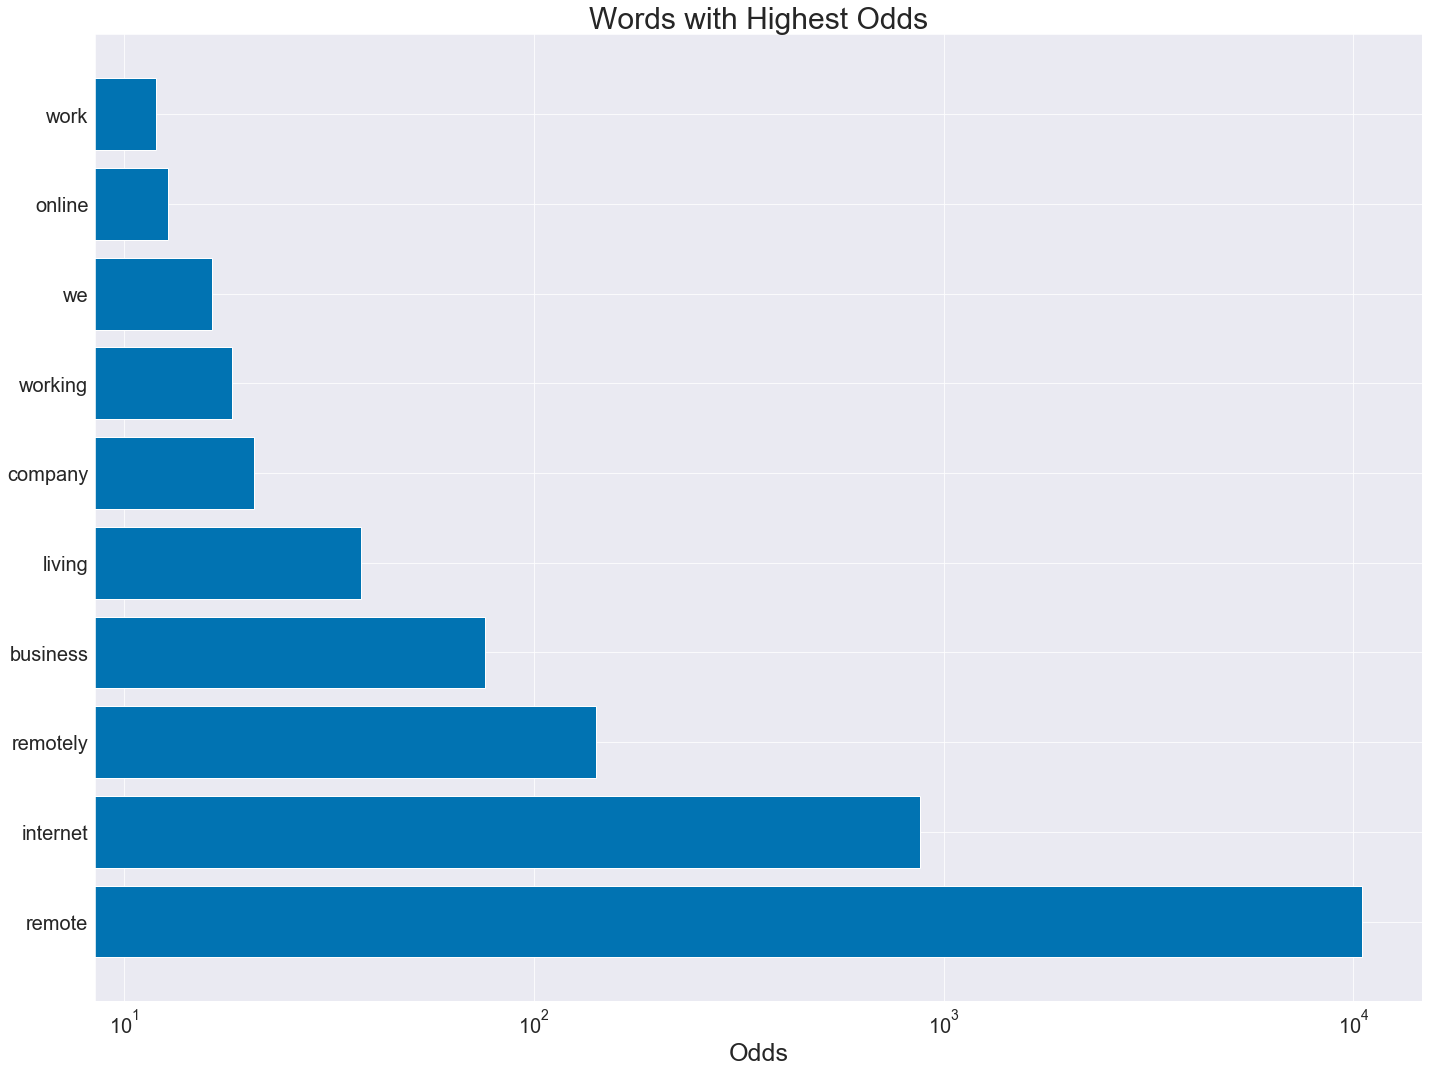

In [17]:
plt.figure(figsize=(20, 15))
plt.barh(y = odds_df.sort_values(by='odds', ascending=False)['odds'].head(10).index,
         width= odds_df.sort_values(by='odds', ascending=False)['odds'].head(10).values,
         log=True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Odds', fontsize=25)
plt.title(f'Words with Highest Odds', fontsize=30)
plt.tight_layout()

-  A post that contains one or a combination of these top 10 words increases the likelihood of it being classified in r/digitalnomad. 
-  Words like `remote`, `internet`, and `online` indicate the importance of technology to digital nomads. 
-  `we` being included in the top 10 can imply that digital nomads are not necessarily traveling or working abroad alone. Whereas in r/solotravel, the name itself suggests so. 

In order to visualize how some of these words compare across subreddits, we'll read in the count vectorize dataframe.

In [18]:
cvec_df = pd.read_csv('../data/countvect.csv')

In [19]:
max_weight = cvec_df.groupby(by='digital_nomad',axis=0)['remote', 'internet', 'business', 'living',
                                           'company', 'working', 'we', 'online'].sum()

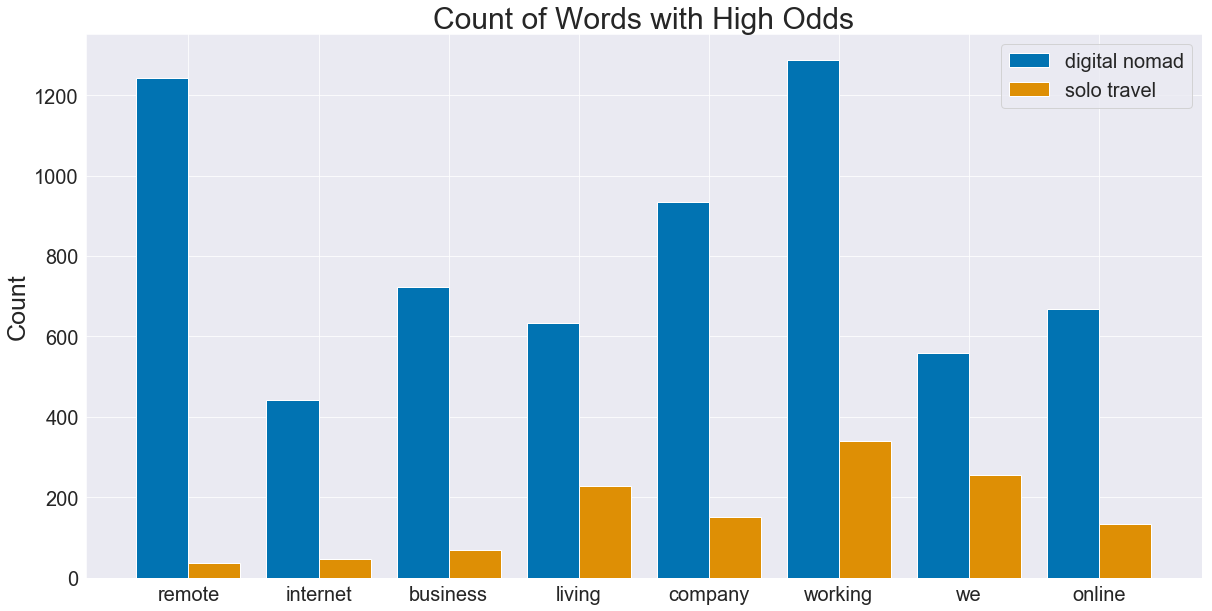

In [20]:
plt.figure(figsize=(20, 10))
plt.bar(x=max_weight.columns,
        height=list(max_weight.loc[1]),
        align='edge',
        width=-.4)
plt.bar(x=max_weight.columns,
        height=list(max_weight.loc[0]),
        align='edge',
        width=.4)
plt.xticks(fontsize=20)
plt.ylabel('Count', fontsize=25)
plt.yticks(fontsize=20)
plt.title('Count of Words with High Odds', fontsize=30)
plt.legend(['digital nomad', 'solo travel'], fontsize=20);

-  All the words with the highests odds have a much higher count in r/digitalnomad than r/solotravel.
-  `remote` (highest odds) occurs over 1200 times in r/digitalnomad, but only about 30 times in r/solotravel. 

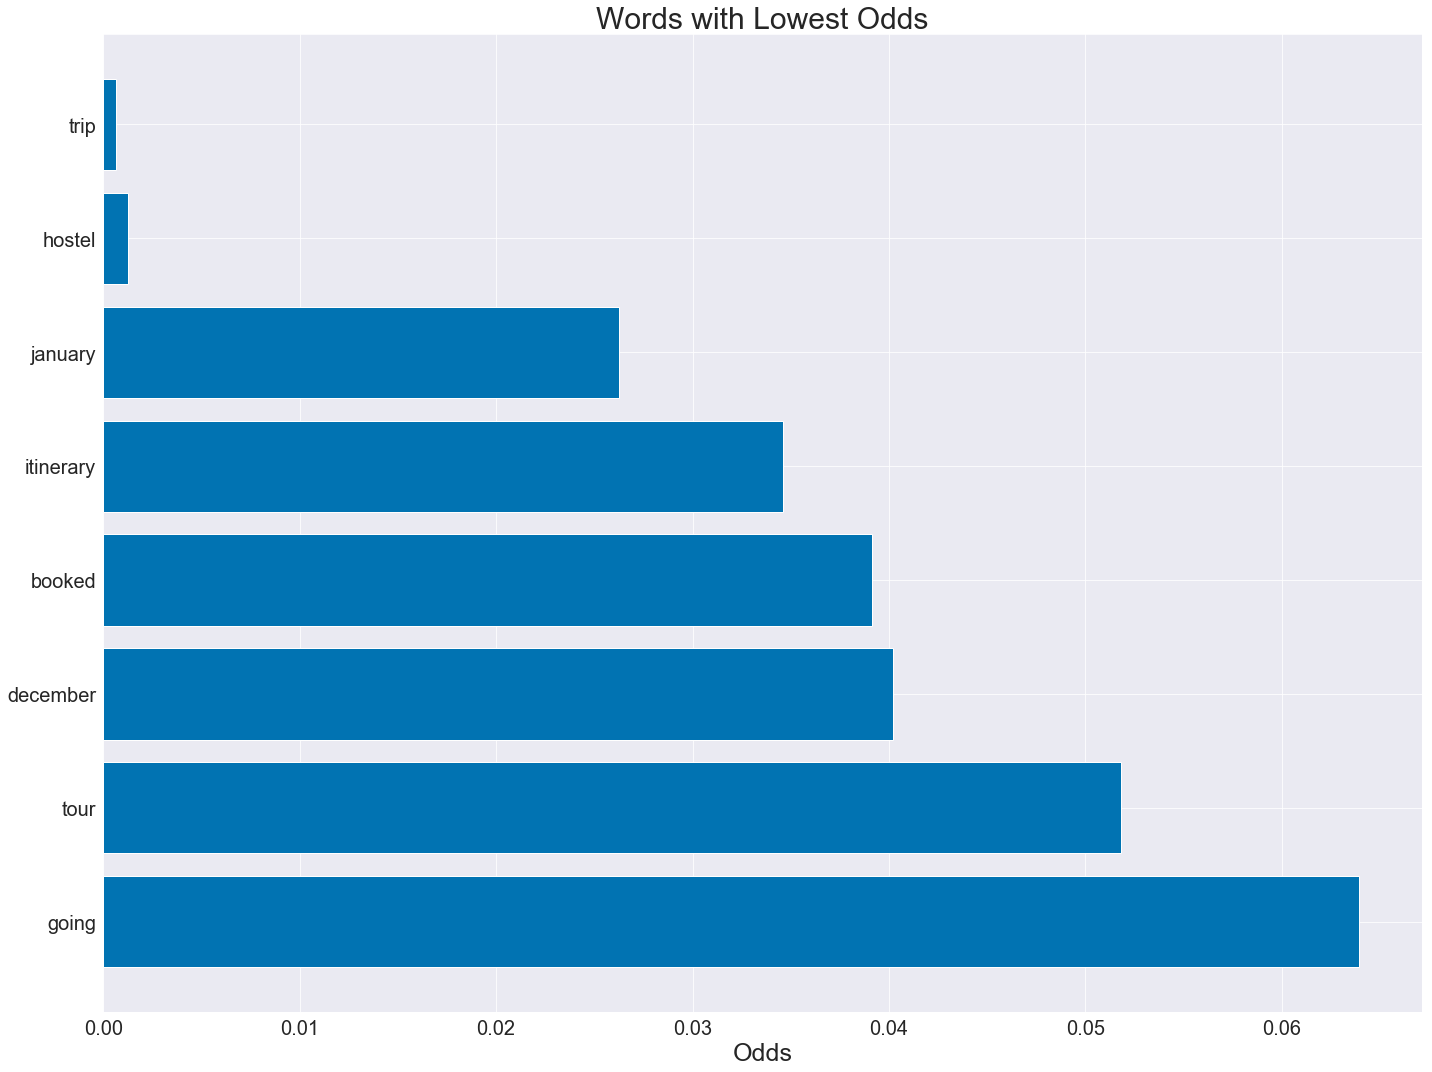

In [21]:
plt.figure(figsize=(20, 15))
plt.barh(y=odds_df.sort_values(by='odds',ascending=False)['odds'].tail(8).index,
         width=odds_df.sort_values(by='odds',ascending=False)['odds'].tail(8).values)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Odds', fontsize=25)
plt.title(f'Words with Lowest Odds', fontsize=30)
plt.tight_layout()

-  A post that contains one or a combination of these words will decrease its likelihood of being classified in r/digitalnomad.
-  Words like `trip`, `hostel`, `itinerary`, `booked` and `tour` imply a short term travel. It's highly unlikely for digital nomads to be residing in a hostel if they're planning to live in any given city for a long period of time. 
-  Since posts from r/solotravel were collected after August 10, 2018, `january` and `december` can indicate users planning trips for the next travel season (winter).

In [22]:
min_weight = cvec_df.groupby(by='digital_nomad',axis=0)['trip', 'hostel', 'january', 'itinerary', 'booked', 'december', 'tour', 'going'].sum()

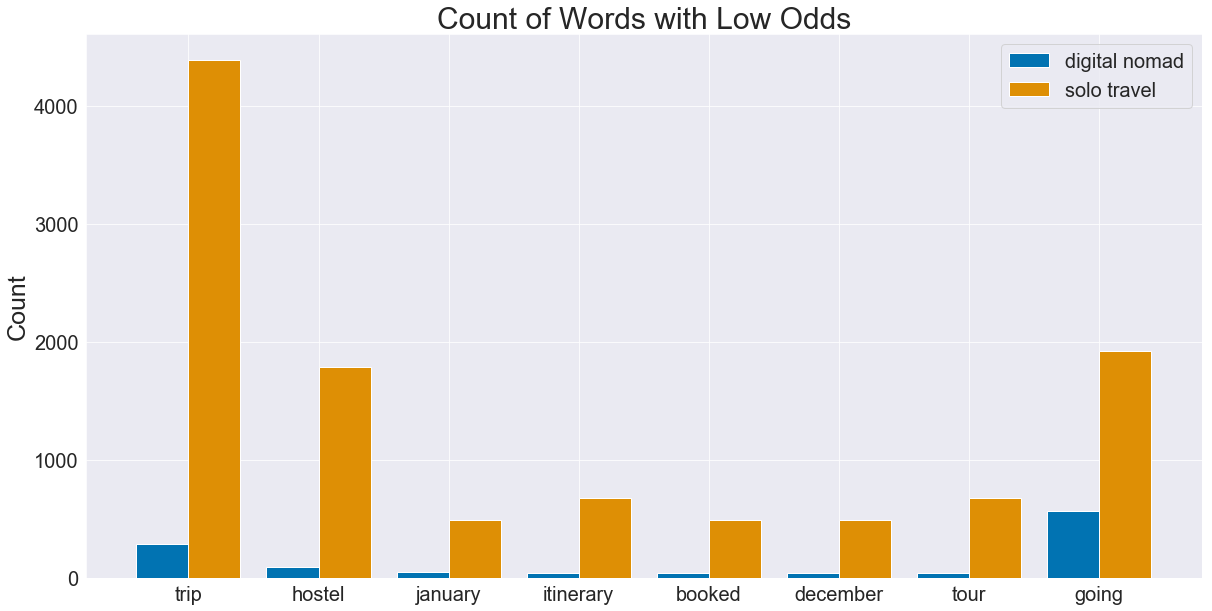

In [23]:
plt.figure(figsize=(20, 10))
plt.bar(x=min_weight.columns,
        height=list(min_weight.loc[1]),
        align='edge',
        width=-.4)
plt.bar(x=min_weight.columns,
        height=list(min_weight.loc[0]),
        align='edge',
        width=.4)
plt.xticks(fontsize=20)
plt.ylabel('Count', fontsize=25)
plt.yticks(fontsize=20)
plt.title('Count of Words with Low Odds', fontsize=30)
plt.legend(['digital nomad', 'solo travel'], fontsize=20);

-  We see the opposite of what was observed with words with high odds earlier. All words with low odds occur much more frequently in r/solotravel than r/digitalnomad.
-  Given that `trip` has the lowest odds of appearing in r/digitalnomad, it has the greatest difference in count between the subreddits.

#### Predictions and Probabilities

We will look at where our model excelled and where it fell short.

In [24]:
lr_pred = gs_logreg.predict(X_test_tfidf_df)

In [25]:
pd.DataFrame(confusion_matrix(y_true = y_test, y_pred = lr_pred),
             index=['Actual Negative', 'Actual Positive'],
             columns=['Predicted Negative', 'Predicted Positive'])

,Predicted Negative,Predicted Positive
Actual Negative,1124,286
Actual Positive,215,1062


Of the 2687 posts in our test set:
-  we correctly predicted 1124 posts to be in r/solotravel (true negative).
-  we correctly predicted 1063 posts to be in r/digitalnomad (true positive).
-  we incorrectly predicted 286 posts to be in r/digitalnomad when they're actually found in r/solotravel (false positive).
-  we incorrectly predicted 215 posts to be in r/solotravel when they're actually found in r/digitalnomad (false negative).

In order to understand why posts were either correctly or incorrectly classified, we'll look at the original post before data cleaning.

##### Predicted Correctly with High Certainty

In [26]:
X_test[(gs_logreg.predict_proba(X_test_tfidf_df)[:, 1] > .7) & (y_test == 1)].head()

,text_lemmatized
707,Being kid Is doing Is possible feasible What s...
930,Has worked Palestine I want cross Bethlehem Je...
4156,Three month stint Northern Baja TJ Rosarito En...
3807,How Start Teaching With VIPKID The Complete Guide
2221,Software Engineer India working time start doe...


In [27]:
posts.loc[930, 'title']

'Has anyone worked from Palestine? I want to cross to Bethlehem from Jerusalem are their any issues travelling with multiple laptops? Is the internet as good as Israel?'

We correctly classified this post to be in r/digitalnomad with high certainty (greater than 70%) because it contains the word `internet`. A post that contains this word is 874.28 times more likely to appear in r/digitalnomad.

##### Predicted Incorrectly with High Certainty

In [28]:
X_test[(gs_logreg.predict_proba(X_test_tfidf_df)[:, 1] > .7) & (y_test != 1)].head()

,text_lemmatized
9276,Is possible boat ship yacht pay ticket working...
9976,Me Myself My New Hammock world I Fit pocket
5991,Best Place Live Your s I m currently living mi...
7213,Air I need vent My gripe hostel people t handl...
10684,Reasons Why You Should Say Yes To Honeymoon Ne...


In [29]:
posts.loc[9276, 'text']

'Is it possible to find a boat/ship/yacht where i can "pay" my ticket with working on it to cross the sea? No particular sea, just asking if its a possibility to get on a boat for free to get to another county.'

We misclassified this post to be in r/digitalnomad with high certainty because of `working`. The word increase the odds of it being misclassified 18.32 times. 

##### Predicted Incorrectly with Low Certainty

In [30]:
X_test[(gs_logreg.predict_proba(X_test_tfidf_df)[:, 1] > .50) & 
       (gs_logreg.predict_proba(X_test_tfidf_df)[:, 1] < .55) & 
       (y_test != 1)].head(10)

,text_lemmatized
8666,Has movie curious wouldn t thought I recently ...
5109,What best story Northern Europe Title say I wa...
5802,Is beginner guide like M d idea start planning
7909,Weather Rio Brazil month Does anybody know wea...
6579,Trans Siberian Railway spring Hello fellow I p...
9206,My experience sunrise Sarankot Nepal
6581,At point start feel confident You hear people ...
7810,Getting dumped whilst Has relationship end whi...
9611,Any suggestion Looking time Was thinking sm in...
6213,Who interesting person met


In [31]:
posts.loc[9611, 'selftext']

'Looking to travel somewhere alone for the first time. Was thinking sm where inclusive or getaway to key west...anyone ever get bored going alone?  I asked a friend to go- my treat of course and was countered with “you’ll have to pay for my passport childcare and time of work too”- how appreciative. Goin at it alone. 🙄'

We misclassified this post to be in r/digitalnomad with low certainty because of `first`, `pay` and `work`. The odds of `first` being in a post in r/digitalnomad is .09 times as likely. On the other hand, `pay` and `work` have high odds. Even though the model misclassified, this decreases our confidence when doing so. 

##### Predicted Correctly with Low Certainty

In [32]:
X_test[(gs_logreg.predict_proba(X_test_tfidf_df)[:, 1] > .50) & 
       (gs_logreg.predict_proba(X_test_tfidf_df)[:, 1] < .55) & 
       (y_test == 1)].head(10)

,text_lemmatized
455,Looking laptop recommendation Hi let know dece...
5017,Buying phone reliably work I Hi I m market new...
1000,How store cash credit card Would love hear safe
4822,Buying flat apartment I m EU want island EU Cu...
3898,Would easier buy second phone I changing SIM c...
2459,Anyone tried Sardinia lifestyle It look perfec...
3491,What did guy personal stuff DN I accumulated l...
3188,Is Lisbon city
5047,FEIE date tax refund oddity I m preliminarily ...
3005,What think average age The title say What opin...


In [33]:
posts.loc[5017, 'text']

"Buying a phone that will reliably work wherever I go? Hi all,\n\nI'm in the market for a new phone. I got my current phone in China and it worked great when I was in a handful of countries in Asia and Africa... But it doesn't seem to work with US carriers. I'll be going to Peru soon and I don't know where I'll go after that, but I don't want to have to worry about compatibility. Any suggestions? My budget is around $    or so -- I certainly don't see any reason to spend $   + on a phone. \n\nLooking forward to hearing what you all have to say. \n\nCheers"

We correctly classified this post to be in r/digitalnomad, but with low certainty. This is because of the words `work` and `going`. `work` increases the odds of the post being in r/digitalnomad 11.96 times, but `going` decreases the odds with a likelihood of 0.06. The presence of both words with high odds and low odds results in a classification with low certainty.

### Random Forest

Random Forest is a collection of decision trees, with each tree only considering a random subset of features. This is preferred over a single decision tree because it prevents overfitting.

**Reason for Choosing Model:** Even though our logistic regression model allows for an easy interpretation of the terms and their importance, Random Forest also allows us to measure feature importance. Using another model may provide us with more insight into the keywords that should be used. 

We will instantiate Random Forest Classifier and perform Grid Search to find the most optimal hyperparameters: 
-  **n_estimators:** Number of trees our model builds before taking an average of the predictions. Increasing the number of trees will allow our model to better learn the data, but having too much can slow down the process considerably. 
-  **min_samples_split:** Minimum number of samples required for a node to split
-  **max_depth:** Maximum number of levels in each tree. As the value increases, so does the information captured. We include the default value of `None` in addition to our other values.

In [34]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [30, 35, 45],
    'min_samples_split': [2, 3, 5, 7, 10],
    'max_depth': [None, 5, 7, 10]
    
}
gs_rf = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs_rf.fit(X_train_tfidf_df, y_train)
print('Score on Training Set:', gs_rf.score(X_train_tfidf_df, y_train))
print('Score on Testing Set:', gs_rf.score(X_test_tfidf_df, y_test))
gs_rf.best_params_

Score on Training Set: 0.9564462092070977
Score on Testing Set: 0.8116858950502419


{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 35}

-  For `y_train`, we will correctly predict the class in which a post belongs in 95.64% of the time.
-  For `y_test`, we will correctly predict the class in which a post belongs in 81.17% of the time. 

#### Takeaways
-  The model is suffering from high variance, with our training score being 14.48% higher than our test score. This can be due to the smaller dataset, resulting in an inadequate number of trees.
-  The accuracy scores are greater than our baseline model of `52.47`.
-  Random Forest performs slighly worse than our Logistic Regression model, with the test score being lower by 0.18%. 

#### Important Features

In [35]:
feat_importance = pd.DataFrame(gs_rf.best_estimator_.feature_importances_, X_train_tfidf_df.columns, columns=['importance'])

In [36]:
top_feat = feat_importance.sort_values('importance', ascending=False).head(20)

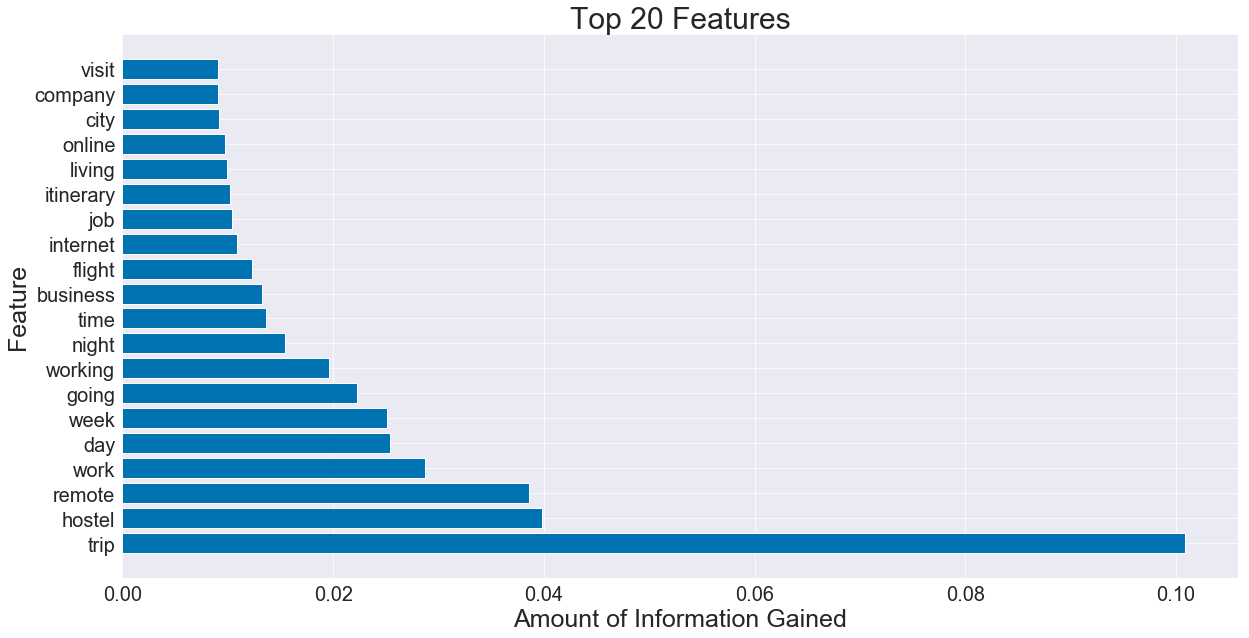

In [37]:
plt.figure(figsize=(20,10))
plt.barh(top_feat.index, top_feat['importance'])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of Information Gained', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

-  There's overlap between our top features and words with very high/low odds in the logistic regression model.
-  `trip` has the most information gained of 11.22% and has the lowest odds of .000646.
-  Words like `week`, `day`, `job` have the highest count in either one or both of the subreddits.

#### Predictions

In [38]:
rf_pred = gs_rf.predict(X_test_tfidf_df)

In [39]:
pd.DataFrame(confusion_matrix(y_true = y_test, 
                              y_pred = rf_pred),
             index=['Actual Negative', 'Actual Positive'],
             columns=['Predicted Negative', 'Predicted Positive'])

,Predicted Negative,Predicted Positive
Actual Negative,1154,256
Actual Positive,250,1027


Of the 2687 posts in our test set:
-  we correctly predicted 1154 posts to be in r/solotravel (true negative).
-  we correctly predicted 1027 posts to be in r/digitalnomad (true positive).
-  we incorrectly predicted 256 posts to be in r/digitalnomad when they're actually found in r/solotravel (false positive).
-  we incorrectly predicted 250 posts to be in r/solotravel when they're actually found in r/digitalnomad (false negative).

### Model Comparison

**Advantages with Logistic Regression:**
-  We can easily determine how likely a post will be classified in r/digitalnomad by taking the exponential of the log odds of success. Even though Random Forest informs us about feature importance, we cannot quickly determine the information gained classifies a post in which class. 
-  Relative to Random Forest, our model is not overfitting. The training score is 1.89% higher than our test score, compared to 14.63%. 
-  There are less false negatives (215) than random forest (250). It may be more beneficial to mistakenly target indviduals who are not digital nomads than to overlook someone who is.

**Advantages with Random Forest:**
-  We have a slightly higher accuracy score of 81.76%. 
-  There are less false positives (256) than logistic regression (286). We are cutting back on costs that we may incur from targeting individuals who do not find our service useful.

### Conclusions and Recommendations

**Use Logistic Regression as Production Model:** With a slightly higher score than Random Forest, Logistic Regression proves to be a more successful and effective model for our purposes. Ultimately, we want to know which words should be used as positive keywords and which should be used as negative keywords to find our target audience. Logistic regression easily provides this distinction with the exponential log odds of success. While Random Forest identifies these keywords, the distinction between positive and negative is not as readily apparant. 

|Positive Keywords|Negative Keywords|
|---|---|
|remote|trip|
|internet|hostel|
|business|itinerary|
|work|booked|

**Positive Keywords:** Websites that contain either one or a combination of these words will be ideal targets for our campaign. Posts with these words have high odds of being in r/digitalnomad, which are exactly the users we're trying to target. When discussed with travel, these words also imply it's not for leisure. Digital nomads will typically be more concerned with internet connection and work, because they ultimately still have work-related responsibilities depsite being in a foreign area.

**Negative Keywords:** To ensure we're allocating resources in the right places, we want to specify these negative keywords and avoid having advertisements on these websites. Posts with these words have low odds of being in r/digitalnomad, which means it concerns a demographic that we have little interest in. All of these words indicate short-term travelers, who will find little to no benefit in our service.

**Next Steps:** Once a campaign budget is determined and we know the cost-benefit trade off, we can return to our production model and optimize for sensitivity or specificity. Without knowing all the costs involved, it's difficult to determine whether false positives or false negatives should be minimized.  